In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
dataset = '/content/drive/MyDrive/dataset-resized'
batch_size = 32
target_size = (224, 224)

In [24]:
train = tf.keras.utils.image_dataset_from_directory(
    dataset,
    validation_split = 0.2,
    label_mode='int',
    subset="training",
    seed=1227,
    image_size=(224, 224),
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [25]:
valid = tf.keras.utils.image_dataset_from_directory(
    dataset,
    validation_split = 0.2,
    label_mode='int',
    subset="training",
    seed=1227,
    image_size=(224, 224),
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [26]:
classes = train.class_names
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [27]:
num_classes = len(classes)

In [28]:
auto = tf.data.AUTOTUNE

In [29]:
val_batches = tf.data.experimental.cardinality(valid)
test = valid.take(val_batches // 5)
valid = valid.skip(val_batches // 5)

In [30]:
train = train.prefetch(auto)
valid = valid.prefetch(auto)

In [31]:
test = test.prefetch(auto)

In [32]:
aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [35]:
input_size = (224, 224, 3)

In [36]:
inputs = tf.keras.Input(shape=input_size)

In [37]:
base = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_size)
base.trainable=False

In [38]:
x = aug(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

In [39]:
model = tf.keras.Model(inputs, output)

In [40]:
lr = 0.001

In [41]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1311

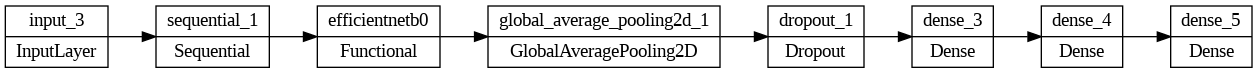

In [43]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=False, rankdir='LR')

In [44]:
history = model.fit(train,
                      epochs=25,
                      validation_data=valid,
                      )

Epoch 1/25
64/64 [==============================] - 494s 8s/step - loss: 0.6212 - accuracy: 0.7839 - val_loss: 0.2733 - val_accuracy: 0.9005
Epoch 2/25
64/64 [==============================] - 16s 240ms/step - loss: 0.3302 - accuracy: 0.8823 - val_loss: 0.1628 - val_accuracy: 0.9463
Epoch 3/25
64/64 [==============================] - 11s 168ms/step - loss: 0.2079 - accuracy: 0.9253 - val_loss: 0.1081 - val_accuracy: 0.9609
Epoch 4/25
64/64 [==============================] - 11s 161ms/step - loss: 0.1412 - accuracy: 0.9505 - val_loss: 0.0832 - val_accuracy: 0.9737
Epoch 5/25
64/64 [==============================] - 11s 169ms/step - loss: 0.1556 - accuracy: 0.9466 - val_loss: 0.0796 - val_accuracy: 0.9701
Epoch 6/25
64/64 [==============================] - 12s 176ms/step - loss: 0.1022 - accuracy: 0.9604 - val_loss: 0.0598 - val_accuracy: 0.9762
Epoch 7/25
64/64 [==============================] - 10s 154ms/step - loss: 0.1133 - accuracy: 0.9540 - val_loss: 0.0915 - val_accuracy: 0.9652
E

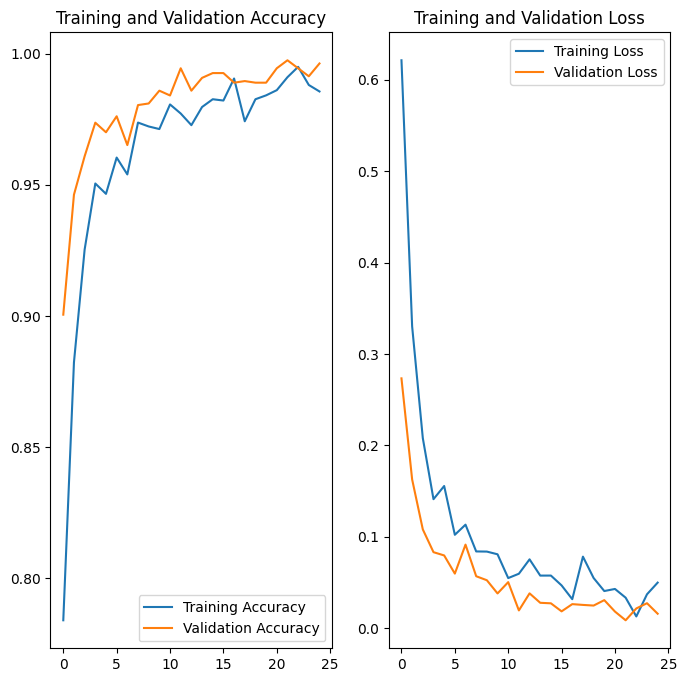

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
#to rotate the images of the dataset to create variatitons and then train the model furhter on those variations
#use this block when you are in a situation with less dataset...bc data bhi nhi milta dhng ka :(
#https://www.tensorflow.org/tutorials/images/classification reference for data augmentation training
"""

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


"""

In [54]:
#this bock is intended for testing....the results are satisfying...

kabaad_url = "https://www.wpt-nl.com/images/module_image/img1_800_600_1593777835.jpg"
kabaad_path = tf.keras.utils.get_file('paper_or_cardboard_Waste', origin=kabaad_url)

img = tf.keras.utils.load_img(
    kabaad_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 26ms/step
This image most likely belongs to paper with a 35.15 percent confidence.


In [56]:
#this block saves the model...the model has to be in .keras format when being saved...it will have 3 components
#refer to https://www.tensorflow.org/guide/keras/serialization_and_saving#:~:text=You%20can%20save%20a%20model,which%20uses%20the%20.keras%20extension.

model.save('/content/drive/MyDrive/tensorflow_garbage_model/garbage_classifier.keras')  # The file needs to end with the .keras extension

